# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
df = pd.read_pickle('base_nfp.pkl')
df.rename(columns={'Data Emissão':'Data_Emissão'}, inplace=True)
df.set_index('Data_Emissão', inplace=True)
df_cut = df['2020-01-01':]
df_cut.dropna(inplace=True)
df_cut.reset_index(inplace=True)
df_cut.head(2)

,Data_Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [28]:
# Dia da semana

df_cut['Dia_semana'] = df_cut['Data_Emissão'].dt.day_name()

In [29]:
# Dummy para fim de semana

df_cut['Fim_de_semana'] = ((df_cut['Data_Emissão'].dt.dayofweek) // 5 == 1).astype(float)

In [30]:
# Dia do mês

df_cut['Dia_mes'] = df_cut['Data_Emissão'].dt.day

In [31]:
# Mês

df_cut['Mes'] = df_cut['Data_Emissão'].dt.month

In [32]:
# Trimestre

df_cut['Trimestre'] = df_cut['Data_Emissão'].dt.quarter

In [33]:
# Ano

df_cut['Ano'] = df_cut['Data_Emissão'].dt.year

In [34]:
df_cut.head(2)

,Data_Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Dia_semana,Fim_de_semana,Dia_mes,Mes,Trimestre
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2020,2,0.0,0,não definido,Wednesday,0.0,1,1,1
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2020,2,0.0,0,Mercado,Wednesday,0.0,1,1,1


In [35]:
df_cut['Valor_NF_5_cat'] = pd.qcut(x=df_cut['Valor NF'], q=5)
df_cut['Valor_NF_10_cat'] = pd.qcut(x=df_cut['Valor NF'], q=10)
df_cut['Valor_NF_20_cat'] = pd.qcut(x=df_cut['Valor NF'], q=20)
df_cut['Valor_NF_50_cat'] = pd.qcut(x=df_cut['Valor NF'], q=50)

In [36]:
df_cut.head(2)

,Data_Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,Dia_semana,Fim_de_semana,Dia_mes,Mes,Trimestre,Valor_NF_5_cat,Valor_NF_10_cat,Valor_NF_20_cat,Valor_NF_50_cat
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2020,2,...,não definido,Wednesday,0.0,1,1,1,"(49.93, 92.314]","(67.53, 92.314]","(67.53, 79.1]","(76.59, 80.98]"
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2020,2,...,Mercado,Wednesday,0.0,1,1,1,"(0.009000000000000001, 25.0]","(14.709, 25.0]","(19.9, 25.0]","(20.79, 22.98]"


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [37]:
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86000 entries, 0 to 85999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data_Emissão         86000 non-null  datetime64[ns]
 1   CNPJ emit.           86000 non-null  object        
 2   Emitente             86000 non-null  object        
 3   No.                  86000 non-null  int64         
 4   Valor NF             86000 non-null  float64       
 5   Data Registro        86000 non-null  datetime64[ns]
 6   Créditos             86000 non-null  float64       
 7   Situação do Crédito  86000 non-null  category      
 8   Ano                  86000 non-null  int64         
 9   Semestre             86000 non-null  int64         
 10  Retorno              86000 non-null  float64       
 11  flag_credito         86000 non-null  int64         
 12  categoria            86000 non-null  object        
 13  Dia_semana           86000 non-

In [38]:
# Definindo o metadados

df_short = df_cut.drop(columns=['Data_Emissão', 'CNPJ emit.', 'Emitente', 'No.', 'Valor NF', 'Data Registro', 'Créditos', 
                     'Situação do Crédito', 'Retorno'])

metadados = pd.DataFrame({'dtype':df_short.dtypes})
metadados

,dtype
Ano,int64
Semestre,int64
flag_credito,int64
categoria,object
Dia_semana,object
Fim_de_semana,float64
Dia_mes,int64
Mes,int64
Trimestre,int64
Valor_NF_5_cat,category


In [39]:
# Atribuindo papéis

metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df_cut.nunique()
metadados

,dtype,papel,nunique
Ano,int64,covariavel,2
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
Dia_semana,object,covariavel,7
Fim_de_semana,float64,covariavel,2
Dia_mes,int64,covariavel,31
Mes,int64,covariavel,12
Trimestre,int64,covariavel,4
Valor_NF_5_cat,category,covariavel,5


In [40]:
# Definindo a função

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [41]:
# Populando a metadados

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>50):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_short[var],5,duplicates='drop'), df_short.flag_credito)
    else: 
        metadados.loc[var, 'IV'] = IV(df_short[var], df_short.flag_credito)
    
metadados

,dtype,papel,nunique,IV
Ano,int64,covariavel,2,0.002589
Semestre,int64,covariavel,2,0.003679
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.240964
Dia_semana,object,covariavel,7,0.006784
Fim_de_semana,float64,covariavel,2,0.005311
Dia_mes,int64,covariavel,31,0.012432
Mes,int64,covariavel,12,0.007772
Trimestre,int64,covariavel,4,0.003010
Valor_NF_5_cat,category,covariavel,5,0.044709


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

**Conclusão:** A variável categoria possui poder preditivo médio e as variáveis categorizadas de Valor_NF possuem poder preditivo fraco. Quando categorizamos a variável continua Valor_NF notamos que aumentar o número de categorias aumentou o valor do IV.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [42]:
df_cut_2 = df_cut.groupby(['Trimestre', 'flag_credito']).size().unstack(fill_value=0)
df_cut_2['soma'] = df_cut_2.sum(axis=1)
df_cut_2

flag_credito,0,1,soma
Trimestre,,,
1,11397,9146,20543
2,11847,8231,20078
3,12377,9720,22097
4,13061,10221,23282


<AxesSubplot:xlabel='Trimestre', ylabel='soma'>

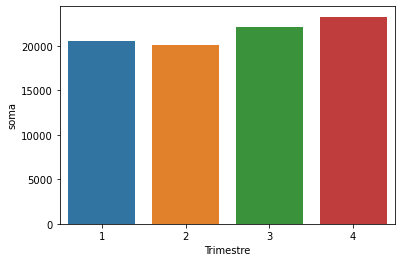

In [43]:
# A quantidade de notas registradas na base por período

fig, ax = plt.subplots()

sns.barplot(data=df_cut_2.reset_index(), x='Trimestre', y='soma', ci=None, ax=ax)

In [44]:
df_cut_3 = df_cut.groupby(['Trimestre', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
df_cut_3['soma'] = df_cut_3.sum(axis=1)
df_cut_3['tx_evento'] = df_cut_3[1]/df_cut_3[0]
df_cut_3.head()

flag_credito             0     1  soma  tx_evento
Trimestre categoria                              
1         Alimentos    374   908  1282   2.427807
          Auto posto   118    34   152   0.288136
          Construção  2041  1811  3852   0.887310
          Farmácia    1794   638  2432   0.355630
          Mercado     3456  3271  6727   0.946470

<AxesSubplot:xlabel='categoria', ylabel='soma'>

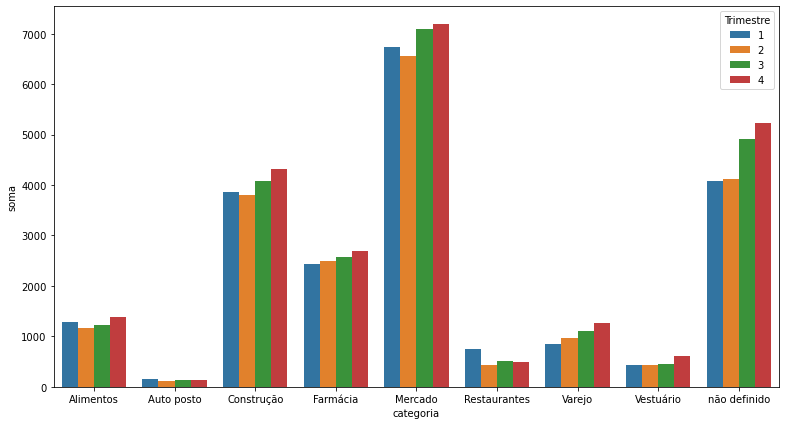

In [45]:
# A quantidade de notas por categoria e por período

fig, ax = plt.subplots(figsize=(13,7))

sns.barplot(data=df_cut_3.reset_index(), x='categoria', y='soma', hue = 'Trimestre', ci=None, ax=ax)

<AxesSubplot:xlabel='categoria', ylabel='tx_evento'>

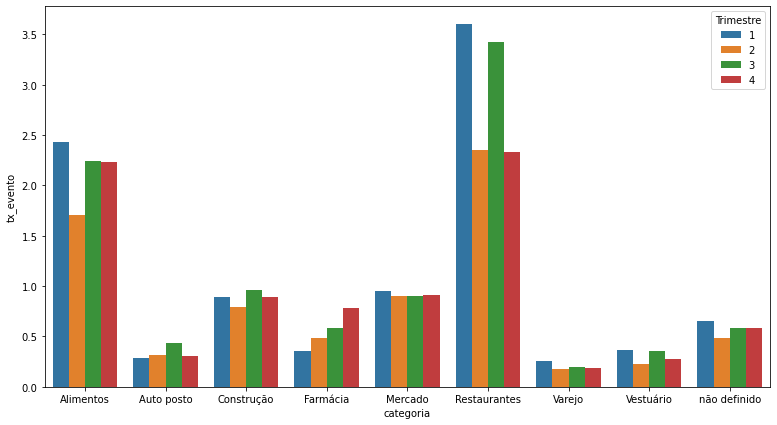

In [46]:
# A proporção de notas com crédito por categoria por período

fig, ax = plt.subplots(figsize=(13,7))

sns.barplot(data=df_cut_3.reset_index(), x='categoria', y='tx_evento', hue = 'Trimestre', ci=None, ax=ax)

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [47]:
df_cut_3['pct_evento']     = df_cut_3[1]/df_cut_3[1].groupby(level=0).sum()
df_cut_3['pct_nao_evento'] = df_cut_3[0]/df_cut_3[0].groupby(level=0).sum()
df_cut_3['WOE'] = np.log(df_cut_3.pct_evento/df_cut_3.pct_nao_evento)
df_cut_3.head()

flag_credito             0     1  soma  tx_evento  pct_evento  pct_nao_evento  \
Trimestre categoria                                                             
1         Alimentos    374   908  1282   2.427807    0.099278        0.032816   
          Auto posto   118    34   152   0.288136    0.003717        0.010354   
          Construção  2041  1811  3852   0.887310    0.198010        0.179082   
          Farmácia    1794   638  2432   0.355630    0.069757        0.157410   
          Mercado     3456  3271  6727   0.946470    0.357643        0.303238   

flag_credito               WOE  
Trimestre categoria             
1         Alimentos   1.107022  
          Auto posto -1.024291  
          Construção  0.100473  
          Farmácia   -0.813831  
          Mercado     0.165017

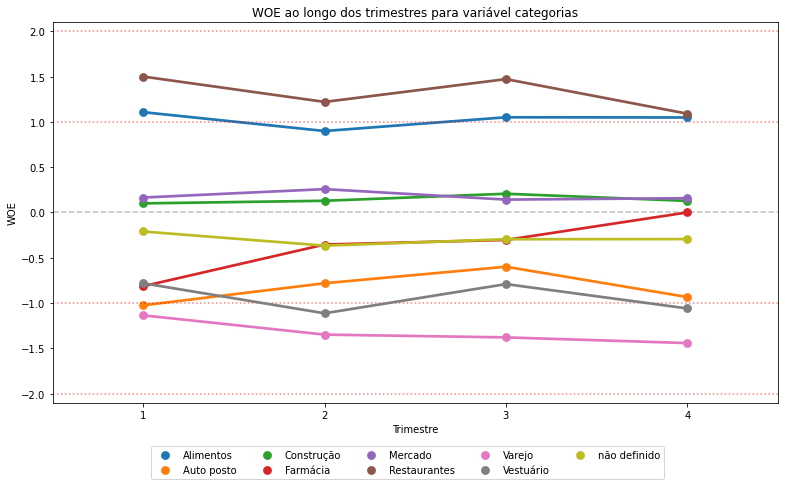

In [48]:
fig, ax = plt.subplots(figsize=(13,7))

# Comando principal do gráfico
sns.pointplot(data=df_cut_3.reset_index(), y = 'WOE', x = 'Trimestre', hue='categoria', ax=ax);

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(2.1, max(df_cut_3.WOE))
ymin = min(-2.1, min(df_cut_3.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(2, linestyle=':'  , color='red', alpha=.5)
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)
ax.axhline(-2, linestyle=':' , color='red', alpha=.5)

ax.set_title(f'WOE ao longo dos trimestres para variável categorias')

ax.legend(bbox_to_anchor=(.85, -.1), ncol=5)

In [49]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    ax.set_title("Information Value de categoria ao longo dos Trimestres")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Trimestres")

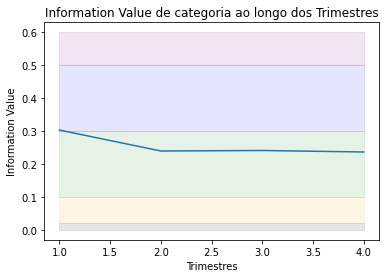

In [50]:
plot_iv(((df_cut_3.pct_evento - df_cut_3.pct_nao_evento)*df_cut_3.WOE).groupby(level=0).sum())

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

**Conclusão:** As categorias Alimentos e Restaurantes são as que possuem maior propoção de notas com retornos maiores que zero, Alimentos apresenta certa estabilidade no tempo, já Restaurantes tem uma alta considerável em Trimestres ímpares.

No gráfico de IV observamos que a variável categoria mantém seu poder preditivo médio ao longo do tempo.
Na categoria Farmácia observamos um fenómeno interessante de aumento constante no valor da WOE, podendo indicar que no futuro a taxa de evento desta categoria aumente.